
# Binary Image Classification Problem

This notebook is a modification of [image_classifier notebook](https://github.com/gsurma/image_classifier).

This notebook trains a model to classify images, in this particular case to classify images into two categories:

* Cats
* Dogs

This notebooks uses an included set of images to train and validate the model. Due to time the notebook uses a reduced set of images.

The results of the model that we will build will not be accurate enough to be used but the goal of the lab is not to build accurrate models but illustrate how OCP and Red Hat Ceph Storage can be used together to run this kind of workloads.

If you want to get an accurate model you can use [this set of images to train the model](https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765) (25000 images). Train the model using that set of images took 35 hours using a laptop with a 4-core **Intel(R) Core(TM) i7-4710HQ CPU @ 2.50GHz** (hyperthreading enabled).

## Installing python modules

We can install additional python modules, if needed:

In [1]:
!pip install kafka
!pip install livelossplot
!pip install boto3

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Some notebook configuration

Disabling scroll in output cells:

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Getting and preparing data

We need first to get the data.

Data will be downloaded from kafka and we will use three datasets:

+ **Train** dataset to train the data.
+ **Validation** dataset to validate the model while training.
+ **Test** dataset to evaluate the trained model.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import CSVLogger

TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
TEST_FILE = "test_file.txt"
MODEL_FILE = "model.h5"

# Data
path = ""
training_data_dir = path + "data/training" 
validation_data_dir = path + "data/validation" 
test_data_dir = path + "data/test" 
predict_data_dir = path + "data/predict"

# Create directories on local storage
# you can create directories on local storage to
# adapt to your needs
! mkdir -p {training_data_dir}
! mkdir -p {training_data_dir}/cat
! mkdir -p {training_data_dir}/dog
! mkdir -p {validation_data_dir}
! mkdir -p {validation_data_dir}/cat
! mkdir -p {validation_data_dir}/dog
! mkdir -p {test_data_dir}
! mkdir -p {test_data_dir}/cat
! mkdir -p {test_data_dir}/dog
! mkdir -p {predict_data_dir}

We download the images from CEPH to local storage:

In [4]:
import os
import ssl
import boto
import boto.s3.connection

# index -> topic
# value -> directory
data = {}
data['train-cat'] = os.path.join(training_data_dir,'cat')
data['train-dog'] = os.path.join(training_data_dir,'dog')
data['validation-cat'] = os.path.join(validation_data_dir,'cat')
data['validation-dog'] = os.path.join(validation_data_dir,'dog')
data['test-cat'] = os.path.join(test_data_dir,'cat')
data['test-dog'] = os.path.join(test_data_dir,'dog')

access_key = 'quy8WT14myuVYD7yz8cn'
secret_key = 'DsqGdYWXr3uOQo0QjSqbCzK3ht3fjTWn57rVZflW'
s3_gateway = 's3.openshift-storage.svc'
s3_port = 443

# do not verify ssl certificate
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

conn = boto.connect_s3(
       aws_access_key_id = access_key,
       aws_secret_access_key = secret_key,
       host = s3_gateway,
       port = s3_port,
       calling_format = boto.s3.connection.OrdinaryCallingFormat(),
       )

def getDataFromS3(conn, bucket_name, directory, files):
    # bind to bucket
    bucket = conn.get_bucket(bucket_name, validate=False)

    for item in files:
        print("Descargando objeto %s del bucket %s." % (item, bucket_name))
        print(os.path.join(directory,item))
        key = bucket.get_key(item)
        key.get_contents_to_filename(os.path.join(directory,item))
    return

datafiles = ['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg']

# download the data from ceph
for item in data.keys():
    getDataFromS3(conn, item, data[item], datafiles)

Descargando objeto 1.jpg del bucket train-cat.
data/training/cat/1.jpg
Descargando objeto 2.jpg del bucket train-cat.
data/training/cat/2.jpg
Descargando objeto 3.jpg del bucket train-cat.
data/training/cat/3.jpg
Descargando objeto 4.jpg del bucket train-cat.
data/training/cat/4.jpg
Descargando objeto 5.jpg del bucket train-cat.
data/training/cat/5.jpg
Descargando objeto 6.jpg del bucket train-cat.
data/training/cat/6.jpg
Descargando objeto 7.jpg del bucket train-cat.
data/training/cat/7.jpg
Descargando objeto 8.jpg del bucket train-cat.
data/training/cat/8.jpg
Descargando objeto 9.jpg del bucket train-cat.
data/training/cat/9.jpg
Descargando objeto 10.jpg del bucket train-cat.
data/training/cat/10.jpg
Descargando objeto 1.jpg del bucket train-dog.
data/training/dog/1.jpg
Descargando objeto 2.jpg del bucket train-dog.
data/training/dog/2.jpg
Descargando objeto 3.jpg del bucket train-dog.
data/training/dog/3.jpg
Descargando objeto 4.jpg del bucket train-dog.
data/training/dog/4.jpg
Desc

We define a convolutional neural network as a python class:

In [3]:
import json

from livelossplot import PlotLossesKeras
from keras.models import model_from_json

# Hyperparams
IMAGE_SIZE = 200
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 32
BATCH_SIZE = 8
DROPOUT = 0.5
LEARNING_RATE = 0.0001

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

# a class implementing a convolutional neural network
class ConvNN:
    
    def __init__(self, image_width=IMAGE_WIDTH, image_height=IMAGE_HEIGHT, epochs=32, batch_size=8, 
                 dropout=DROPOUT, learning_rate=LEARNING_RATE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), 
                 training_dir=training_data_dir, validation_dir=validation_data_dir, test_dir=test_data_dir, 
                 model_filename='cnn', verbose=True):
        
        self.image_width = image_width
        self.image_height = image_height
        self.epochs = epochs
        self.batch_size = batch_size
        self.dropout = dropout
        self.lr = learning_rate
        self.input_shape = input_shape
        self.training_dir = training_dir
        self.validation_dir = validation_dir
        self.test_dir = test_dir
        self.model_filename = model_filename
        self.verbose = verbose
        self.accuracy = ''
    
    # create the convolutional neural network
    def create(self):
        self.model = Sequential()

        self.model.add(Conv2D(32, 3, 3, border_mode='same', input_shape=self.input_shape, activation='relu'))
        self.model.add(Conv2D(32, 3, 3, border_mode='same', activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        self.model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
        self.model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        self.model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
        self.model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        self.model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
        self.model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        self.model.add(Flatten())
        self.model.add(Dense(256, activation='relu'))
        self.model.add(Dropout(self.dropout))

        self.model.add(Dense(256, activation='relu'))
        self.model.add(Dropout(self.dropout))

        self.model.add(Dense(1))
        self.model.add(Activation('sigmoid'))

        self.model.compile(loss='binary_crossentropy',
                            optimizer=RMSprop(lr=self.lr),
                            metrics=['accuracy'])
        
        with open(self.model_filename + '.txt', "w") as fh:
            self.model.summary(print_fn=lambda line: fh.write(line + "\n"))
            
    # train the model
    def train(self):
        # Data augmentation
        training_data_generator = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True)
        validation_data_generator = ImageDataGenerator(rescale=1./255)

        # Data preparation
        training_generator = training_data_generator.flow_from_directory(
            self.training_dir,
            target_size=(self.image_width, self.image_height),
            batch_size=self.batch_size,
            shuffle=True,
            class_mode="binary")
        validation_generator = validation_data_generator.flow_from_directory(
            self.validation_dir,
            target_size=(self.image_width, self.image_height),
            batch_size=self.batch_size,
            shuffle=True,
            class_mode="binary")

        # Training
        self.model.fit_generator(
                    training_generator,
                    steps_per_epoch=len(training_generator.filenames) // self.batch_size,
                    epochs=self.epochs,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator.filenames) // self.batch_size,
                    callbacks=[PlotLossesKeras(), CSVLogger(self.model_filename + '_logs.csv',
                                                            append=False,
                                                            separator=";")], 
                    verbose=self.verbose)
        
    # save the trained model
    def save(self):
        self.model.save_weights(self.model_filename + '.h5')
        model_json = self.model.to_json()
        with open(self.model_filename + '.json', 'w',  encoding="utf8") as json_file:
            #json.dump(model_json, json_file, ensure_ascii=False)
            json.dump(model_json, json_file)
    
    # load a previously trained model
    def load(self, filename):
        self.model.load_weights(filename)
    
    # evaluate model
    def evaluate(self, test_size=1):
        test_file = self.model_filename + 'test.txt'
        test_data_generator = ImageDataGenerator(rescale=1./255)
        test_generator = test_data_generator.flow_from_directory(
                            self.test_dir,
                            target_size=(self.image_width, self.image_height),
                            batch_size=1,
                            class_mode="binary", 
                            shuffle=False)
        
        open(test_file, "w")
        probabilities = self.model.predict_generator(test_generator, test_size)
        for index, probability in enumerate(probabilities):
            image_path = os.path.join(self.test_dir, test_generator.filenames[index]) 
            img = mpimg.imread(image_path)
            with open(test_file, "a") as fh:
                fh.write(str(probability[0]) + " for: " + image_path + "\n")
            plt.imshow(img)
            if probability > 0.5:
                plt.title("%.2f" % (probability[0]*100) + "% dog.")
            else:
                plt.title("%.2f" % ((1-probability[0])*100) + "% cat.")
            plt.show()
                          
    def predict(self, images):       
        return self.model.predict_classes(images)

## Training the model

The first step is to train the model.

You only will have to click in the bellow Cell and press **Shift + Enter** to run the cell.

This will start the model training and you could see two charts:

* Log-loss (cost function)
* Accuracy

You will have to wait until it finishes.

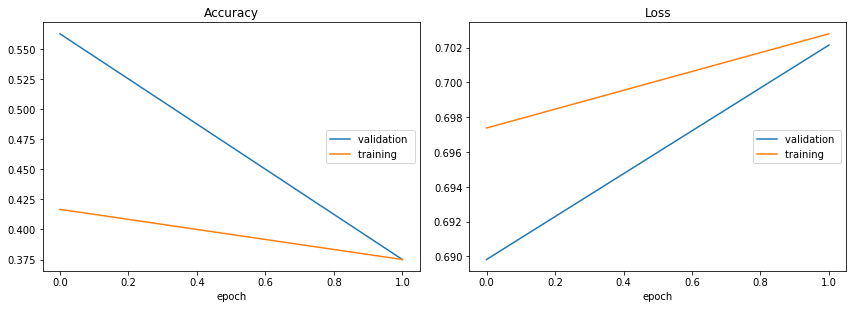

Accuracy
	validation       	 (min:    0.375, max:    0.562, cur:    0.375)
	training         	 (min:    0.375, max:    0.417, cur:    0.375)
Loss
	validation       	 (min:    0.690, max:    0.702, cur:    0.702)
	training         	 (min:    0.697, max:    0.703, cur:    0.703)
2/2 [==============================] - 22s 11s/step - loss: 0.7028 - acc: 0.3750 - val_loss: 0.7022 - val_acc: 0.3750


In [6]:
poorly_trained_model = ConvNN(epochs=2, model_filename='poorly_trained_model')

poorly_trained_model.create()

poorly_trained_model.train()

poorly_trained_model.save()

Found 20 images belonging to 2 classes.


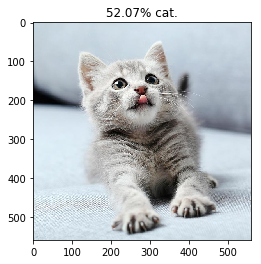

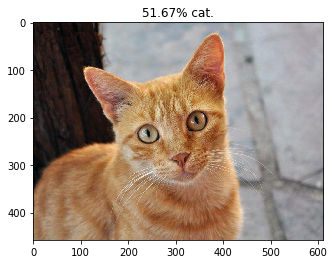

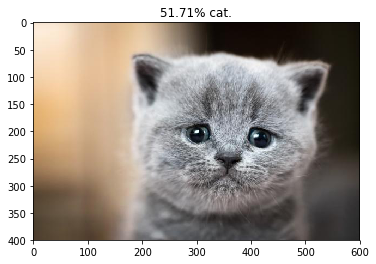

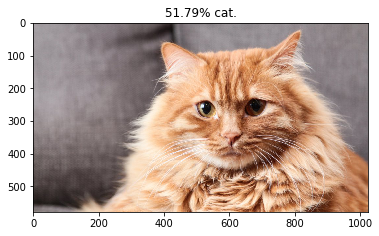

In [7]:
poorly_trained_model.evaluate(test_size=4)

## Loading a well trained model

As we can see the accuracy of the model can be "improved". We train the model with a small dataset so the model will be a bad model as we can see.

Now we will load a better model which was previously trained with a bigger dataset: 25000 images.

We download a better trained model:

In [4]:
import urllib.request
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

well_trained_model_url = 'https://jadebustos.ddns.net/~jadebustos/trained-model.h5'
well_trained_model_filename = 'well-trained-model.h5'

urllib.request.urlretrieve (well_trained_model_url, well_trained_model_filename)

well_trained_model = ConvNN(epochs=2, model_filename='binary-classification/well_trained_model')

well_trained_model.create()

well_trained_model.load(well_trained_model_filename)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(200, 200,..., activation="relu", padding="same")`
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
/opt/app-root/lib/python3.6/site-packages/ipykernel_launc

Instructions for updating:
keep_dims is deprecated, use keepdims instead


/opt/app-root/lib/python3.6/site-packages/keras/utils/conv_utils.py:87: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])


Found 20 images belonging to 2 classes.


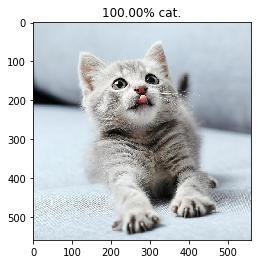

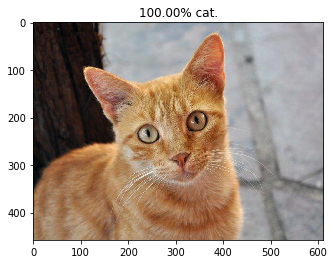

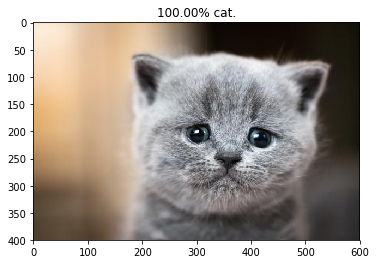

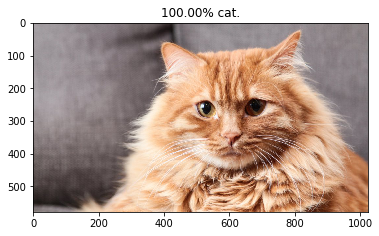

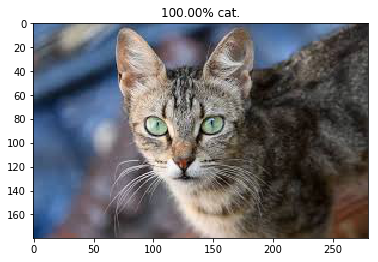

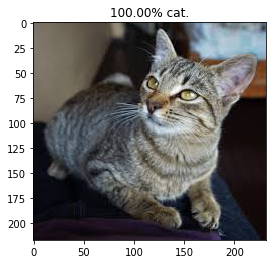

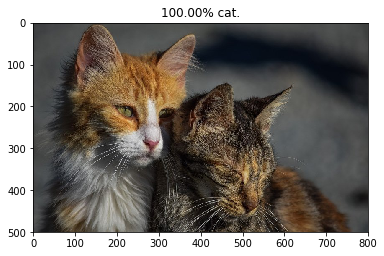

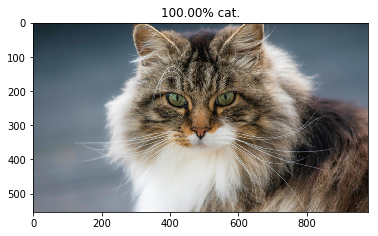

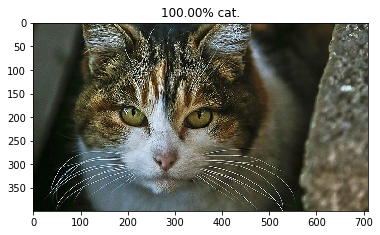

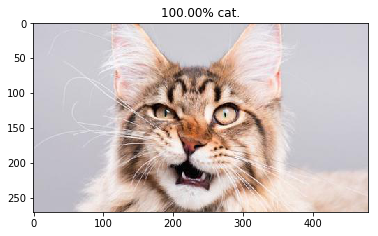

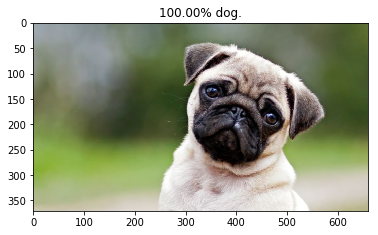

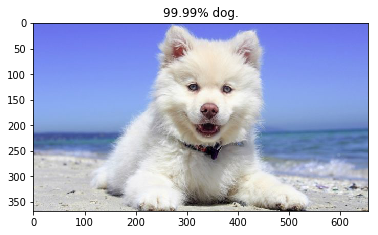

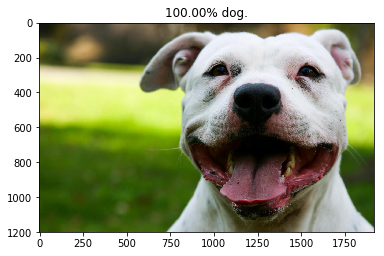

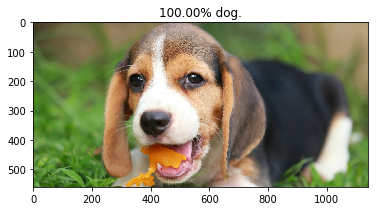

In [9]:
well_trained_model.evaluate(test_size=14)

# Predict

Predictions using new images from kafka topic **predict**. So we read kafka topic and store the images on local disk:

In [5]:
from PIL import Image
import numpy as np

from keras import backend as K
import ssl
import os

# you can install python modules if they are not available on the notebook
from kafka import KafkaConsumer, TopicPartition
from kafka.errors import KafkaError

# you should change this value to fit your environment
kafkaendpoint = 'odh-message-bus-kafka-bootstrap-binary-classification.apps.cluster-syone-a5ce.syone-a5ce.example.opentlc.com:443'

def get_images_from_kafka(kafkaendpoint, topic, dest_dir):
    consumer = KafkaConsumer(bootstrap_servers=kafkaendpoint,
                             auto_offset_reset='earliest',
                             enable_auto_commit=False,
                             ssl_context= ssl._create_unverified_context(),
                             security_protocol='SSL',
                             heartbeat_interval_ms=1000,
                             group_id='consumer-group2')
    
    # assigning consumer to a kafka partition
    tp = TopicPartition(topic=topic, partition=0)
    consumer.assign([tp])
    consumer.seek_to_beginning(tp)  
    # lastOffset in topic
    lastOffset = consumer.end_offsets([tp])[tp]

    # read images
    count = 1
    for message in consumer:
        # stop reading when there is no more messages on topic
        if consumer.position(tp) == lastOffset:
            image_filename = os.path.join(dest_dir, str(count)+'.jpg')
            message = message.value
            fd = open(image_filename,'wb')
            fd.write(message)
            fd.close()
            break
            
        image_filename = os.path.join(dest_dir, str(count)+'.jpg')
        message = message.value
        fd = open(image_filename,'wb')
        fd.write(message)
        fd.close()
        count += 1
    
    consumer.close()
    
    return

# read images from kafka and store it to local disk
predict_topic = 'predict'
get_images_from_kafka(kafkaendpoint, predict_topic, predict_data_dir)

# predict images
predict_images = [os.path.join(predict_data_dir, f) for f in os.listdir(predict_data_dir) 
                      if os.path.isfile(os.path.join(predict_data_dir, f))]

def classify(data, model):
    dogs = []
    cats = []
    images = []
    # reshape the image to be used in the neural network
    for item in data:
        image = Image.open(item)
        image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
        images.append(np.array(image))

    images = np.array(images)
    if K.image_data_format() == 'channels_first':
        images = images.reshape(images.shape[0], 3, IMAGE_WIDTH, IMAGE_HEIGHT)
    else:
        images = images.reshape(images.shape[0], IMAGE_WIDTH, IMAGE_HEIGHT, 3)
               
    return model.predict(images)

# predict the data from kafka
predictions = classify(predict_images, well_trained_model)

6/6 [==============================] - 2s 274ms/step


## Predicted Cats

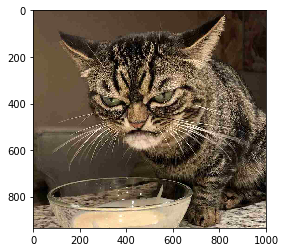

In [6]:
# 0 -> cat
# 1 -> dog
for item in range(0, len(predictions)):
    if predictions[item][0] == 0:
        plt.figure()
        img = mpimg.imread(predict_images[item])
        plt.imshow(img)

## Predicted Dogs


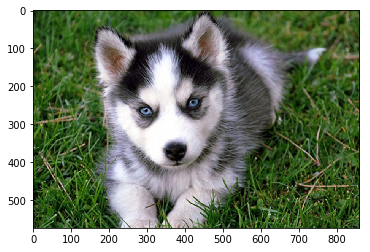

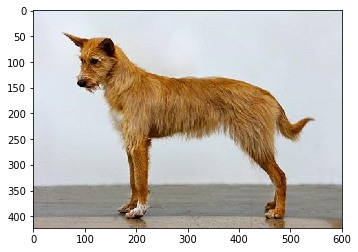

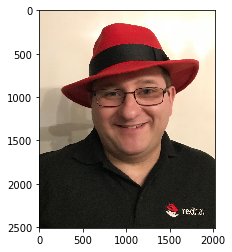

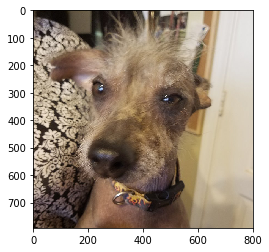

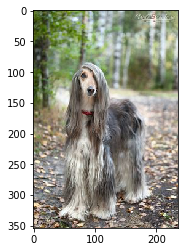

In [7]:
for item in range(0, len(predictions)):
    if predictions[item][0] == 1:
        plt.figure()
        img = mpimg.imread(predict_images[item])
        plt.imshow(img)

## Exporting the model

In [42]:
# store model to disk
well_trained_model.save()

# filenames
model_weights = os.path.join('binary-classification', 'well_trained_model.h5')

# bucket
bucket_name = 'models'

# upload files to bucket
bucket = conn.get_bucket(bucket_name, validate=False)

key = bucket.new_key('well_trained_model.h5')
key.set_contents_from_filename(model_weights)

8382